**import libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from tensorflow.keras.utils import plot_model
import re
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from tensorflow.keras.models import Model
from keras.layers import Dense, Input, Embedding, LSTM, Conv1D, Dropout, MaxPooling1D, BatchNormalization, Bidirectional, GlobalMaxPooling1D, Flatten

In [2]:
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

### **Read Dataset**

In [12]:
pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [13]:
!gdown --id 1xhd-vLaS5jCgEJOCa9cNzauWFAGh2200

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xhd-vLaS5jCgEJOCa9cNzauWFAGh2200
To: /content/Amazon_Unlocked_Mobile.csv
100% 132M/132M [00:01<00:00, 70.3MB/s]


In [14]:
df = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv',
                 error_bad_lines=False,  
                 encoding='utf-8')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [16]:
df.shape

(413840, 6)

**Prepare Dataset**

In [185]:
# 1,2 stars -> Negative
# 3 stars   -> Neutral
# 4,5 stars -> Positive

In [37]:
df['sentiment'] = df['Rating'].apply(lambda x: "negative" if x <= 2 else "positive" if x >= 4 else "neutral")

In [38]:
df.head(3)

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,positive
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,positive
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,positive


In [39]:
df['sentiment'].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [44]:
df['sentiment'].value_counts()

positive    284997
negative     97078
neutral      31765
Name: sentiment, dtype: int64

In [47]:
positive = df[(df['sentiment'] == 'positive')]
negative = df[(df['sentiment'] == 'negative')]
neutral = df[(df['sentiment'] == 'neutral')]

In [48]:
print(positive.shape)
print(negative.shape)
print(neutral.shape)

(284997, 7)
(97078, 7)
(31765, 7)


In [49]:
data = pd.concat([positive, neutral, negative], axis=0)

In [50]:
data.shape

(413840, 7)

In [51]:
data.tail()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,sentiment
413817,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,1,This is the second junk Convoy I have owned. T...,0.0,negative
413820,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,1,They said phone was normal wear but it was a l...,0.0,negative
413828,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,1,Would not work,0.0,negative
413831,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,1,"Item was listed as new, but was not. When we t...",0.0,negative
413834,Samsung Convoy U640 Phone for Verizon Wireless...,Samsung,79.95,1,used hard,0.0,negative


### **Preprocessing**

In [58]:
sentences = data['Reviews'].values
#one_hot_encodings
y = pd.get_dummies(data['sentiment']).values

In [59]:
print(sentences.shape)
print(y.shape)

(413840,)
(413840, 3)


In [60]:
sentences[0]

"I feel so LUCKY to have found this used (phone to us & not used hard at all), phone on line from someone who upgraded and sold this one. My Son liked his old one that finally fell apart after 2.5+ years and didn't want an upgrade!! Thank you Seller, we really appreciate it & your honesty re: said used phone.I recommend this seller very highly & would but from them again!!"

In [61]:
tokenizer = RegexpTokenizer(r'\w+')
sentences_tokenize = [tokenizer.tokenize(str(s).lower()) for s in sentences]

In [62]:
sentences_tokenize[0]

['i',
 'feel',
 'so',
 'lucky',
 'to',
 'have',
 'found',
 'this',
 'used',
 'phone',
 'to',
 'us',
 'not',
 'used',
 'hard',
 'at',
 'all',
 'phone',
 'on',
 'line',
 'from',
 'someone',
 'who',
 'upgraded',
 'and',
 'sold',
 'this',
 'one',
 'my',
 'son',
 'liked',
 'his',
 'old',
 'one',
 'that',
 'finally',
 'fell',
 'apart',
 'after',
 '2',
 '5',
 'years',
 'and',
 'didn',
 't',
 'want',
 'an',
 'upgrade',
 'thank',
 'you',
 'seller',
 'we',
 'really',
 'appreciate',
 'it',
 'your',
 'honesty',
 're',
 'said',
 'used',
 'phone',
 'i',
 'recommend',
 'this',
 'seller',
 'very',
 'highly',
 'would',
 'but',
 'from',
 'them',
 'again']

In [63]:
stop_words = stopwords.words("english")
stop_words.extend([':)', '.', ',', '!', '?', '#', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '18', 'also', 'ls', 'xl', '2xl', 'u', 'w', 'c', 'ua', '3rd', '20', '30', '40', '50', '60', '70', '80', '90', '100', 'è', 'et', 'zu', 'le', '2nd', 'ago'])

In [64]:
len(stop_words)

221

In [65]:
sentences_tokenize_filtered = [[w for w in sentence if w not in stop_words] for sentence in sentences_tokenize]

In [66]:
sentences_tokenize_filtered[0]

['feel',
 'lucky',
 'found',
 'used',
 'phone',
 'us',
 'used',
 'hard',
 'phone',
 'line',
 'someone',
 'upgraded',
 'sold',
 'one',
 'son',
 'liked',
 'old',
 'one',
 'finally',
 'fell',
 'apart',
 'years',
 'want',
 'upgrade',
 'thank',
 'seller',
 'really',
 'appreciate',
 'honesty',
 'said',
 'used',
 'phone',
 'recommend',
 'seller',
 'highly',
 'would']

In [67]:
porter_stemmer = PorterStemmer()
sentences_tokenize_filtered_stem = [[porter_stemmer.stem(w) for w in sentence] for sentence in sentences_tokenize_filtered]

In [68]:
lem = WordNetLemmatizer()
sentences_tokenize_filtered_lem = [[lem.lemmatize(w) for w in sentence] for sentence in sentences_tokenize_filtered_stem]

In [69]:
sentences_tokenize_filtered_lem[0]

['feel',
 'lucki',
 'found',
 'use',
 'phone',
 'u',
 'use',
 'hard',
 'phone',
 'line',
 'someon',
 'upgrad',
 'sold',
 'one',
 'son',
 'like',
 'old',
 'one',
 'final',
 'fell',
 'apart',
 'year',
 'want',
 'upgrad',
 'thank',
 'seller',
 'realli',
 'appreci',
 'honesti',
 'said',
 'use',
 'phone',
 'recommend',
 'seller',
 'highli',
 'would']

In [70]:
corpus = []
for sentence in sentences_tokenize_filtered_lem:
  s = ''
  s = ' '.join(sentence)
  corpus.append(s) 

In [71]:
corpus[0]

'feel lucki found use phone u use hard phone line someon upgrad sold one son like old one final fell apart year want upgrad thank seller realli appreci honesti said use phone recommend seller highli would'

**keras Tokenizer**

In [72]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [73]:
with open('tokenizer.h5', 'wb') as f:
    pickle.dump(tokenizer, f)

In [74]:
vocab_size = len(tokenizer.word_index) + 1

In [75]:
vocab_size

53474

In [76]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [77]:
data_to_sequences = tokenizer.texts_to_sequences(corpus)

In [78]:
maxlen = max_length(data_to_sequences)
maxlen

2737

In [79]:
data_to_sequences[0]

[113,
 1575,
 223,
 3,
 1,
 182,
 3,
 216,
 1,
 374,
 352,
 206,
 556,
 6,
 362,
 7,
 111,
 6,
 380,
 983,
 1040,
 97,
 38,
 206,
 79,
 70,
 20,
 1074,
 3224,
 139,
 3,
 1,
 53,
 70,
 366,
 12]

In [80]:
pad_data_to_sequences = pad_sequences(data_to_sequences, padding='post', maxlen=300)

In [81]:
pad_data_to_sequences[0]

array([ 113, 1575,  223,    3,    1,  182,    3,  216,    1,  374,  352,
        206,  556,    6,  362,    7,  111,    6,  380,  983, 1040,   97,
         38,  206,   79,   70,   20, 1074, 3224,  139,    3,    1,   53,
         70,  366,   12,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [82]:
print(pad_data_to_sequences.shape)
print(y.shape)

(413840, 300)
(413840, 3)


In [132]:
X_train, X_test, y_train, y_test = train_test_split(pad_data_to_sequences, y, test_size=0.25, shuffle=True, random_state=50)

In [133]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(310380, 300)
(103460, 300)
(310380, 3)
(103460, 3)


## **Neural Networks**

### **Naive Bayes -> (NB)**

In [223]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [240]:
Y = data['sentiment'].values

In [241]:
Y

array(['positive', 'positive', 'positive', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [242]:
Y = pd.factorize(Y)[0]

In [243]:
Y

array([0, 0, 0, ..., 2, 2, 2])

In [244]:
XTrain, XTest, ytrain, ytest = train_test_split(corpus, Y, test_size=0.25, shuffle=True, random_state=50)

In [245]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

In [246]:
train_vectors = vectorizer.fit_transform(XTrain)
test_vectors = vectorizer.transform(XTest)

In [247]:
model = MultinomialNB()
model.fit(train_vectors, ytrain)

MultinomialNB()

In [248]:
model.score(test_vectors, ytest)

0.8404407500483279

In [249]:
y_pred = model.predict(test_vectors)

In [250]:
report = classification_report(ytest, y_pred, output_dict=True)

In [251]:
report

{'0': {'precision': 0.8499318039393977,
  'recall': 0.9709569196647904,
  'f1-score': 0.9064224030611576,
  'support': 71239},
 '1': {'precision': 0.5138539042821159,
  'recall': 0.05198114409478914,
  'f1-score': 0.09441166261714681,
  'support': 7849},
 '2': {'precision': 0.8163322839825212,
  'recall': 0.7128672246840637,
  'f1-score': 0.7610995509801773,
  'support': 24372},
 'accuracy': 0.8404407500483279,
 'macro avg': {'precision': 0.7267059974013449,
  'recall': 0.5786017628145478,
  'f1-score': 0.5873112055528272,
  'support': 103460},
 'weighted avg': {'precision': 0.8165202155496915,
  'recall': 0.8404407500483279,
  'f1-score': 0.8105855496621368,
  'support': 103460}}

### **Logistic Regresion**

In [260]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [252]:
Y = data['sentiment'].values

In [253]:
Y

array(['positive', 'positive', 'positive', ..., 'negative', 'negative',
       'negative'], dtype=object)

In [254]:
Y = pd.factorize(Y)[0]

In [255]:
Y

array([0, 0, 0, ..., 2, 2, 2])

In [256]:
XTrain, XTest, ytrain, ytest = train_test_split(corpus, Y, test_size=0.3, shuffle=True, random_state=50)

In [257]:
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 8,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

In [258]:
train_vectors = vectorizer.fit_transform(XTrain)
test_vectors = vectorizer.transform(XTest)

In [261]:
log_model = LogisticRegression()

In [262]:
log_model.fit(train_vectors, ytrain)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [263]:
log_model.score(test_vectors, ytest)

0.8713754107867775

In [264]:
y_pred = log_model.predict(test_vectors)

In [265]:
report = classification_report(ytest, y_pred, output_dict=True)

In [266]:
report

{'0': {'precision': 0.904904286423567,
  'recall': 0.9587468583786312,
  'f1-score': 0.9310477920308775,
  'support': 85545},
 '1': {'precision': 0.5497664390945023,
  'recall': 0.1632174098570514,
  'f1-score': 0.2517068355679855,
  'support': 9374},
 '2': {'precision': 0.8016203553068263,
  'recall': 0.8427804193890466,
  'f1-score': 0.8216852602264579,
  'support': 29233},
 'accuracy': 0.8713754107867775,
 'macro avg': {'precision': 0.7520970269416319,
  'recall': 0.6549148958749097,
  'f1-score': 0.6681466292751069,
  'support': 124152},
 'weighted avg': {'precision': 0.8537705041309069,
  'recall': 0.8713754107867775,
  'f1-score': 0.8540040310111456,
  'support': 124152}}

### **CNN Model**

In [134]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=300))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(64, 4, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(32, 2, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.4))
model.add(layers.Conv1D(64, 2, activation='relu'))
model.add(layers.MaxPooling1D(2))
model.add(layers.Dropout(0.2))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [135]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [136]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 50)           2673700   
                                                                 
 batch_normalization_2 (Batc  (None, 300, 50)          200       
 hNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 300, 50)           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 297, 64)           12864     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 148, 64)          0         
 1D)                                                             
                                                                 
 dropout_11 (Dropout)        (None, 148, 64)          

In [137]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=512)

Epoch 1/20
607/607 [==============================] - 22s 35ms/step - loss: 0.5923 - accuracy: 0.7841 - val_loss: 0.5637 - val_accuracy: 0.8590
Epoch 2/20
607/607 [==============================] - 21s 35ms/step - loss: 0.4191 - accuracy: 0.8568 - val_loss: 0.4349 - val_accuracy: 0.8669
Epoch 3/20
607/607 [==============================] - 20s 33ms/step - loss: 0.3834 - accuracy: 0.8674 - val_loss: 0.4104 - val_accuracy: 0.8710
Epoch 4/20
607/607 [==============================] - 20s 33ms/step - loss: 0.3604 - accuracy: 0.8736 - val_loss: 0.3890 - val_accuracy: 0.8755
Epoch 5/20
607/607 [==============================] - 21s 35ms/step - loss: 0.3440 - accuracy: 0.8778 - val_loss: 0.4168 - val_accuracy: 0.8775
Epoch 6/20
607/607 [==============================] - 21s 35ms/step - loss: 0.3296 - accuracy: 0.8813 - val_loss: 0.3969 - val_accuracy: 0.8775
Epoch 7/20
607/607 [==============================] - 21s 35ms/step - loss: 0.3175 - accuracy: 0.8842 - val_loss: 0.3711 - val_accuracy:

In [138]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

3234/3234 [==============================] - 11s 3ms/step - loss: 0.3078 - accuracy: 0.9053
Accuracy: 90.53%


In [150]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

3234/3234 [==============================] - 7s 2ms/step


In [151]:
y_true = np.argmax(y_true, axis=1)

In [152]:
y_true[80]

2

In [153]:
y_pred[80]

2

In [154]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88     24372
           1       0.71      0.38      0.50      7849
           2       0.92      0.98      0.95     71239

    accuracy                           0.91    103460
   macro avg       0.84      0.74      0.77    103460
weighted avg       0.90      0.91      0.90    103460



In [155]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

print(precision_recall_fscore_support(y_true, y_pred, average='micro'))

print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

(0.8394891584281106, 0.7404973564092185, 0.7734716736758291, None)
(0.9052870674656872, 0.9052870674656872, 0.9052870674656872, None)
(0.8975931317873107, 0.9052870674656872, 0.8971208273620039, None)


### **LSTM Model**

In [186]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=300))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True)))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))

In [187]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [188]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 300, 50)           2673700   
                                                                 
 batch_normalization_5 (Batc  (None, 300, 50)          200       
 hNormalization)                                                 
                                                                 
 dropout_23 (Dropout)        (None, 300, 50)           0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 300, 512)         628736    
 nal)                                                            
                                                                 
 global_max_pooling1d_5 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                      

In [189]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=512)

Epoch 1/5
607/607 [==============================] - 184s 297ms/step - loss: 0.4128 - accuracy: 0.8504 - val_loss: 0.3482 - val_accuracy: 0.8743
Epoch 2/5
607/607 [==============================] - 179s 295ms/step - loss: 0.3226 - accuracy: 0.8846 - val_loss: 0.2992 - val_accuracy: 0.8931
Epoch 3/5
607/607 [==============================] - 179s 296ms/step - loss: 0.2817 - accuracy: 0.9010 - val_loss: 0.2872 - val_accuracy: 0.9006
Epoch 4/5
607/607 [==============================] - 179s 296ms/step - loss: 0.2525 - accuracy: 0.9125 - val_loss: 0.2770 - val_accuracy: 0.9062
Epoch 5/5
607/607 [==============================] - 180s 296ms/step - loss: 0.2307 - accuracy: 0.9201 - val_loss: 0.2773 - val_accuracy: 0.9098


In [190]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

3234/3234 [==============================] - 69s 21ms/step - loss: 0.2773 - accuracy: 0.9098
Accuracy: 90.98%


In [191]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

3234/3234 [==============================] - 47s 14ms/step


In [192]:
y_true = np.argmax(y_true, axis=1)

In [193]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     24372
           1       0.69      0.43      0.53      7849
           2       0.93      0.97      0.95     71239

    accuracy                           0.91    103460
   macro avg       0.83      0.76      0.79    103460
weighted avg       0.90      0.91      0.90    103460



In [194]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

print(precision_recall_fscore_support(y_true, y_pred, average='micro'))

print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

(0.8342537573801705, 0.7613803798911819, 0.7879909040371124, None)
(0.9097622269476126, 0.9097622269476126, 0.9097622269476126, None)
(0.9027816094411751, 0.9097622269476126, 0.9037887769844241, None)


### **CNN-LSTM Model**

In [156]:
embedding_dim = 50

i = Input(shape=(300,))
x = Embedding(vocab_size, embedding_dim, input_length=300)(i)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Conv1D(64, 4, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 3, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(2)(x)
x = Conv1D(32, 2, padding='same', activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(3)(x)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

In [157]:
model = Model(i, x)

In [158]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [159]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_3 (Embedding)     (None, 300, 50)           2673700   
                                                                 
 batch_normalization_3 (Batc  (None, 300, 50)          200       
 hNormalization)                                                 
                                                                 
 dropout_15 (Dropout)        (None, 300, 50)           0         
                                                                 
 conv1d_9 (Conv1D)           (None, 300, 64)           12864     
                                                                 
 dropout_16 (Dropout)        (None, 300, 64)           0         
                                                           

In [160]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=512)

Epoch 1/20
607/607 [==============================] - 32s 48ms/step - loss: 0.4741 - accuracy: 0.8319 - val_loss: 0.3938 - val_accuracy: 0.8664
Epoch 2/20
607/607 [==============================] - 28s 46ms/step - loss: 0.3686 - accuracy: 0.8707 - val_loss: 0.3309 - val_accuracy: 0.8770
Epoch 3/20
607/607 [==============================] - 28s 46ms/step - loss: 0.3373 - accuracy: 0.8795 - val_loss: 0.3187 - val_accuracy: 0.8849
Epoch 4/20
607/607 [==============================] - 28s 46ms/step - loss: 0.3153 - accuracy: 0.8879 - val_loss: 0.3093 - val_accuracy: 0.8886
Epoch 5/20
607/607 [==============================] - 28s 46ms/step - loss: 0.2984 - accuracy: 0.8965 - val_loss: 0.3010 - val_accuracy: 0.8959
Epoch 6/20
607/607 [==============================] - 28s 46ms/step - loss: 0.2826 - accuracy: 0.9032 - val_loss: 0.2869 - val_accuracy: 0.9014
Epoch 7/20
607/607 [==============================] - 28s 46ms/step - loss: 0.2711 - accuracy: 0.9085 - val_loss: 0.2856 - val_accuracy:

In [161]:
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

3234/3234 [==============================] - 18s 6ms/step - loss: 0.2699 - accuracy: 0.9149
Accuracy: 91.49%


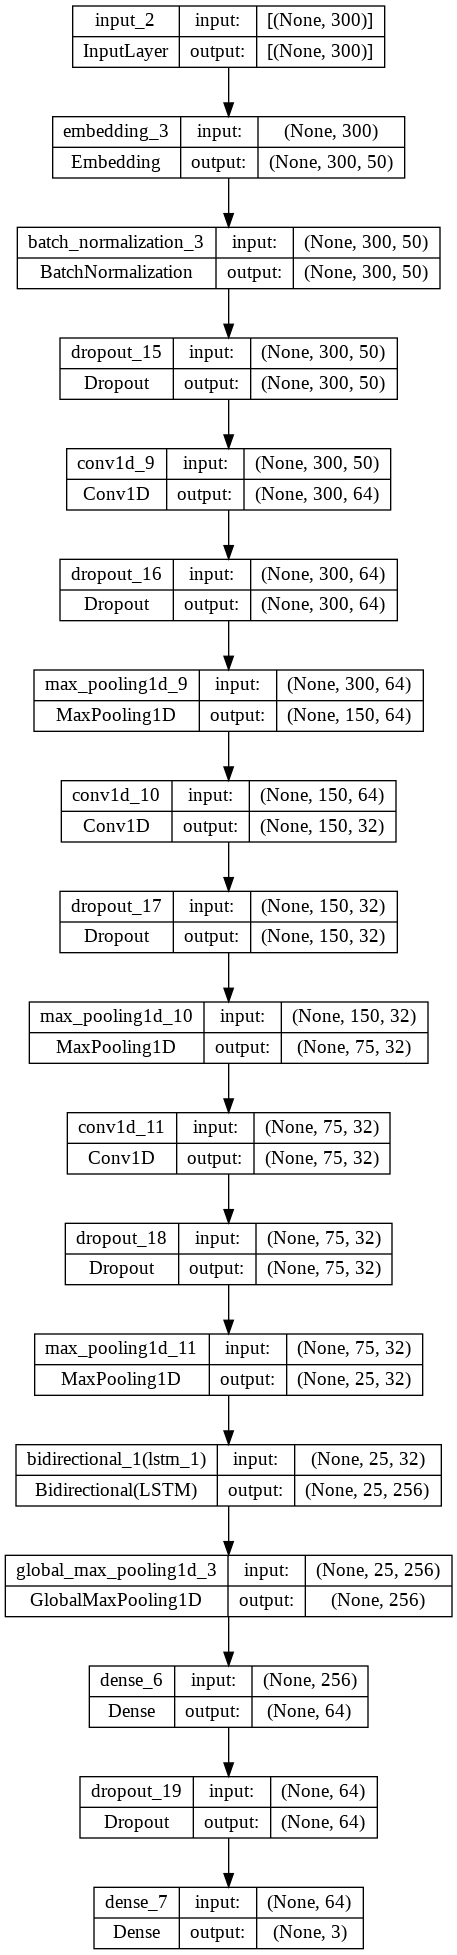

In [162]:
plot_model(model, show_shapes=True)

In [163]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

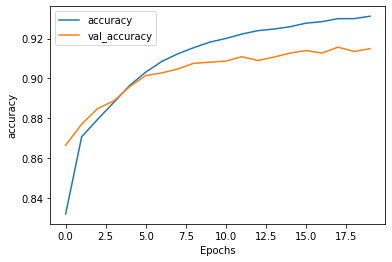

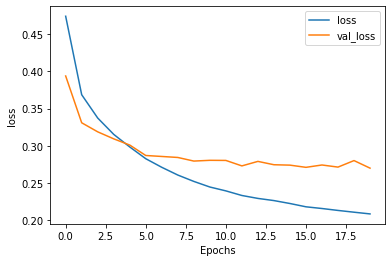

In [164]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [ ]:
y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

  95/3234 [..............................] - ETA: 13s

In [167]:
y_true = np.argmax(y_true, axis=1)

In [168]:
y_true

array([0, 2, 2, ..., 2, 2, 2])

In [169]:
y_pred

array([0, 2, 2, ..., 2, 2, 2])

In [170]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     24372
           1       0.82      0.41      0.54      7849
           2       0.93      0.98      0.95     71239

    accuracy                           0.91    103460
   macro avg       0.88      0.76      0.80    103460
weighted avg       0.91      0.91      0.91    103460



In [171]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

print(precision_recall_fscore_support(y_true, y_pred, average='micro'))

print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

(0.8775058536186009, 0.7598796235300281, 0.7952305311014332, None)
(0.9149139764160061, 0.9149139764160061, 0.9149139764160061, None)
(0.9109015286955956, 0.9149139764160061, 0.907212495595733, None)


In [174]:
cm = confusion_matrix(y_true, y_pred)

In [175]:
cm

array([[21805,   341,  2226],
       [ 1746,  3196,  2907],
       [ 1228,   355, 69656]])

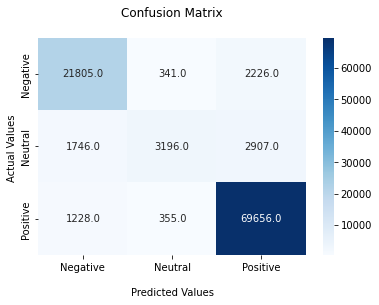

In [180]:
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.1f')

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Negative','Neutral', 'Positive'])
ax.yaxis.set_ticklabels(['Negative','Neutral', 'Positive'])

plt.show()